##Class LSTM

In [14]:
import numpy as np

In [15]:
def he_init(shape, input_size):
    return np.random.randn(*shape) * np.sqrt(2 / input_size)

def xavier_init(shape, input_size):
    return np.random.randn(*shape) * np.sqrt(1 / input_size)

###Optimizers

In [17]:
def adam_optimizer(parameter, grad, m, v, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
  """
  Update parameters using the Adam optimizer.
  Adjusts the learning rate based on the moving averages of the gradient and squared gradient.
  """
  m = beta1 * m + (1 - beta1) * grad
  v = beta2 * v + (1 - beta2) * (grad**2)
  m_hat = m / (1 - beta1**t)
  v_hat = v / (1 - beta2**t)
  update = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
  return parameter - update, m, v


def momentum_optimizer(parameter, grad, velocity, learning_rate=0.01, momentum=0.9):
  """
  Update parameters using the momentum optimizer.
  Tracks the direction of the gradient and updates the parameters accordingly.
  """
  velocity = momentum * velocity - learning_rate * grad
  return parameter + velocity, velocity


def rmsprop_optimizer(parameter, grad, squared_grad, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
  """
  Update parameters using the RMSprop optimizer.
  Adjusts the learning rate based on the moving average of the squared gradient.
  """
  squared_grad = decay_rate * squared_grad + (1 - decay_rate) * grad**2
  update = learning_rate * grad / (np.sqrt(squared_grad) + epsilon)
  return parameter - update, squared_grad

###LSTM class

In [26]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, optimizer='adam'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.optimizer = optimizer

        # Use He initialization for ReLU-like activations (forget, input, output gates)
        self.weight_forget = he_init((hidden_size, hidden_size + input_size), hidden_size + input_size)
        self.weight_input = he_init((hidden_size, hidden_size + input_size), hidden_size + input_size)
        self.weight_output = he_init((hidden_size, hidden_size + input_size), hidden_size + input_size)

        # Use Xavier initialization for tanh activation
        self.weight_cell = xavier_init((hidden_size, hidden_size + input_size), hidden_size + input_size)

        # Use Xavier initialization for the output layer
        self.weight_hidden_to_output = xavier_init((output_size, hidden_size), hidden_size)


        self.bias_forget = np.zeros((hidden_size, 1))
        self.bias_input = np.zeros((hidden_size, 1))
        self.bias_cell = np.zeros((hidden_size, 1))
        self.bias_output = np.zeros((hidden_size, 1))
        self.bias_hidden_to_output = np.zeros((output_size, 1))


        self.time_for_adam = 1
        self.momentum_for_adam = {}
        self.velocity_for_adam = {}
        self.velocity_for_momentum = {}
        self.squared_grad_for_RMSProp = {}


        for param in ['weight_forget', 'weight_input', 'weight_cell', 'weight_output', 'weight_hidden_to_output',
                      'bias_forget', 'bias_input', 'bias_cell', 'bias_output', 'bias_hidden_to_output']:
            self.momentum_for_adam[param] = np.zeros_like(getattr(self, param))
            self.velocity_for_adam[param] = np.zeros_like(getattr(self, param))
            self.velocity_for_momentum[param] = np.zeros_like(getattr(self, param))
            self.squared_grad_for_RMSProp[param] = np.zeros_like(getattr(self, param))

    def forward(self, inputs):
        hidden_state = np.zeros((self.hidden_size, 1))
        cell_state = np.zeros((self.hidden_size, 1))
        self.inputs_cache = inputs
        self.hidden_states_cache = {0: hidden_state}
        self.cell_states_cache = {0: cell_state}

        for t, input_t in enumerate(inputs):
            combined_input = np.row_stack((hidden_state, input_t))

            forget_gate = self.sigmoid(np.dot(self.weight_forget, combined_input) + self.bias_forget)
            input_gate = self.sigmoid(np.dot(self.weight_input, combined_input) + self.bias_input)
            cell_candidate = np.tanh(np.dot(self.weight_cell, combined_input) + self.bias_cell)
            output_gate = self.sigmoid(np.dot(self.weight_output, combined_input) + self.bias_output)

            cell_state = forget_gate * cell_state + input_gate * cell_candidate
            hidden_state = output_gate * np.tanh(cell_state)

            self.hidden_states_cache[t + 1] = hidden_state
            self.cell_states_cache[t + 1] = cell_state

        output = np.dot(self.weight_hidden_to_output, hidden_state) + self.bias_hidden_to_output
        return output, hidden_state


    def backward(self, output_gradient, learning_rate=0.01):
        sequence_length = len(self.inputs_cache)

        grad_weight_forget = np.zeros_like(self.weight_forget)
        grad_weight_input = np.zeros_like(self.weight_input)
        grad_weight_cell = np.zeros_like(self.weight_cell)
        grad_weight_output = np.zeros_like(self.weight_output)
        grad_weight_hidden_to_output = np.zeros_like(self.weight_hidden_to_output)

        grad_bias_forget = np.zeros_like(self.bias_forget)
        grad_bias_input = np.zeros_like(self.bias_input)
        grad_bias_cell = np.zeros_like(self.bias_cell)
        grad_bias_output = np.zeros_like(self.bias_output)
        grad_bias_hidden_to_output = np.zeros_like(self.bias_hidden_to_output)

        grad_hidden = np.dot(self.weight_hidden_to_output.T, output_gradient)
        grad_cell = np.zeros_like(grad_hidden)

        #calculate from back
        for t in reversed(range(sequence_length)):
            combined_input = np.row_stack((self.hidden_states_cache[t], self.inputs_cache[t]))
            prev_cell_state = self.cell_states_cache[t]
            cell_state = self.cell_states_cache[t + 1]
            hidden_state = self.hidden_states_cache[t + 1]

            forget_gate = self.sigmoid(np.dot(self.weight_forget, combined_input) + self.bias_forget)
            input_gate = self.sigmoid(np.dot(self.weight_input, combined_input) + self.bias_input)
            cell_candidate = np.tanh(np.dot(self.weight_cell, combined_input) + self.bias_cell)
            output_gate = self.sigmoid(np.dot(self.weight_output, combined_input) + self.bias_output)

            # BPTT
            grad_output_gate = np.tanh(cell_state) * grad_hidden
            grad_cell += grad_hidden * output_gate * (1 - np.tanh(cell_state)**2)
            grad_cell_candidate = input_gate * grad_cell
            grad_input_gate = cell_candidate * grad_cell
            grad_forget_gate = prev_cell_state * grad_cell

            grad_combined = (np.dot(self.weight_forget.T, grad_forget_gate * forget_gate * (1 - forget_gate)) +
                             np.dot(self.weight_input.T, grad_input_gate * input_gate * (1 - input_gate)) +
                             np.dot(self.weight_cell.T, grad_cell_candidate * (1 - cell_candidate**2)) +
                             np.dot(self.weight_output.T, grad_output_gate * output_gate * (1 - output_gate)))

            grad_hidden = grad_combined[:self.hidden_size, :]
            grad_cell = forget_gate * grad_cell

            grad_weight_forget += np.dot(grad_forget_gate * forget_gate * (1 - forget_gate), combined_input.T)
            grad_weight_input += np.dot(grad_input_gate * input_gate * (1 - input_gate), combined_input.T)
            grad_weight_cell += np.dot(grad_cell_candidate * (1 - cell_candidate**2), combined_input.T)
            grad_weight_output += np.dot(grad_output_gate * output_gate * (1 - output_gate), combined_input.T)
            grad_weight_hidden_to_output += np.dot(output_gradient, hidden_state.T)

            grad_bias_forget += grad_forget_gate * forget_gate * (1 - forget_gate)
            grad_bias_input += grad_input_gate * input_gate * (1 - input_gate)
            grad_bias_cell += grad_cell_candidate * (1 - cell_candidate**2)
            grad_bias_output += grad_output_gate * output_gate * (1 - output_gate)
            grad_bias_hidden_to_output += output_gradient

        # Clipping the Gradient between [-1. 1] to prevent gradient Exploding
        gradients = [grad_weight_forget, grad_weight_input, grad_weight_cell, grad_weight_output,
                     grad_weight_hidden_to_output, grad_bias_forget, grad_bias_input, grad_bias_cell,
                     grad_bias_output, grad_bias_hidden_to_output]
        for grad in gradients:
            np.clip(grad, -1, 1, out=grad)


        # Update the parameters using custom optimizer
        for param, grad in [('weight_forget', grad_weight_forget), ('weight_input', grad_weight_input),
                            ('weight_cell', grad_weight_cell), ('weight_output', grad_weight_output),
                            ('weight_hidden_to_output', grad_weight_hidden_to_output),
                            ('bias_forget', grad_bias_forget), ('bias_input', grad_bias_input),
                            ('bias_cell', grad_bias_cell), ('bias_output', grad_bias_output),
                            ('bias_hidden_to_output', grad_bias_hidden_to_output)]:

            if self.optimizer == 'adam':
                updated_param, self.momentum_for_adam[param], self.velocity_for_adam[param] = adam_optimizer(
                    getattr(self, param), grad, self.momentum_for_adam[param], self.velocity_for_adam[param],
                    self.time_for_adam, learning_rate)
            elif self.optimizer == 'momentum':
                updated_param, self.velocity_for_momentum[param] = momentum_optimizer(
                    getattr(self, param), grad, self.velocity_for_momentum[param], learning_rate)
            elif self.optimizer == 'rmsprop':
                updated_param, self.squared_grad_for_RMSProp[param] = rmsprop_optimizer(
                    getattr(self, param), grad, self.squared_grad_for_RMSProp[param], learning_rate)
            else:  # default to simple gradient descent
                updated_param = getattr(self, param) - learning_rate * grad

            setattr(self, param, updated_param)

        if self.optimizer == 'adam':
            self.time_for_adam += 1


    def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))

##Model Training

In [27]:
def trainer(model, X, y, epochs=100, learning_rate=0.01, batch_size=32, early_stopping_patience=5):
  losses = []
  best_loss = float('inf')
  patience_counter = 0

  for epoch in range(epochs):
    epoch_loss = 0
    # Shuffle the data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled = [X[i] for i in indices]
    y_shuffled = [y[i] for i in indices]

    # Mini-batch
    for i in range(0, len(X), batch_size):
      batch_X = X_shuffled[i:i+batch_size]
      batch_y = y_shuffled[i:i+batch_size]

      batch_loss = 0
      for j in range(len(batch_X)):
        inputs = batch_X[j]
        target = batch_y[j]

        # Forward pass
        output, _ = model.forward(inputs)
        loss = np.mean((output - target)**2)
        batch_loss += loss

        # Backward pass
        d_y = 2 * (output - target) / len(batch_X)
        model.backward(d_y, learning_rate=learning_rate)

      epoch_loss += batch_loss / len(batch_X)

    average_loss = epoch_loss / (len(X) // batch_size)
    losses.append(average_loss)

    # Print progress
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {average_loss:.4f}')
        print("-"*25)

    # Early stopping
    if average_loss < best_loss:
      best_loss = average_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch}')
        break

  return losses

In [28]:
def generate_sine_wave(samples, period=20):
    x = np.arange(samples)
    return np.sin(2 * np.pi * x / period).reshape(-1, 1)

def prepare_data(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence) - n_steps):
        X.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(X), np.array(y)

In [29]:
samples = 1000
sine_wave = generate_sine_wave(samples)
n_steps = 50
X, y = prepare_data(sine_wave, n_steps)

In [30]:
input_size = 1
hidden_size = 50
output_size = 1

In [31]:
model = LSTM(input_size, hidden_size, output_size, optimizer='adam')

In [32]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [33]:
losses = trainer(model, X_train, y_train, epochs=100, learning_rate=0.01, batch_size=32)

Epoch 0, Loss: 0.1693
-------------------------
Epoch 10, Loss: 0.0006
-------------------------
Epoch 20, Loss: 0.0013
-------------------------
Early stopping triggered at epoch 21


##Model Visualization

In [34]:
import matplotlib.pyplot as plt

### Training loss

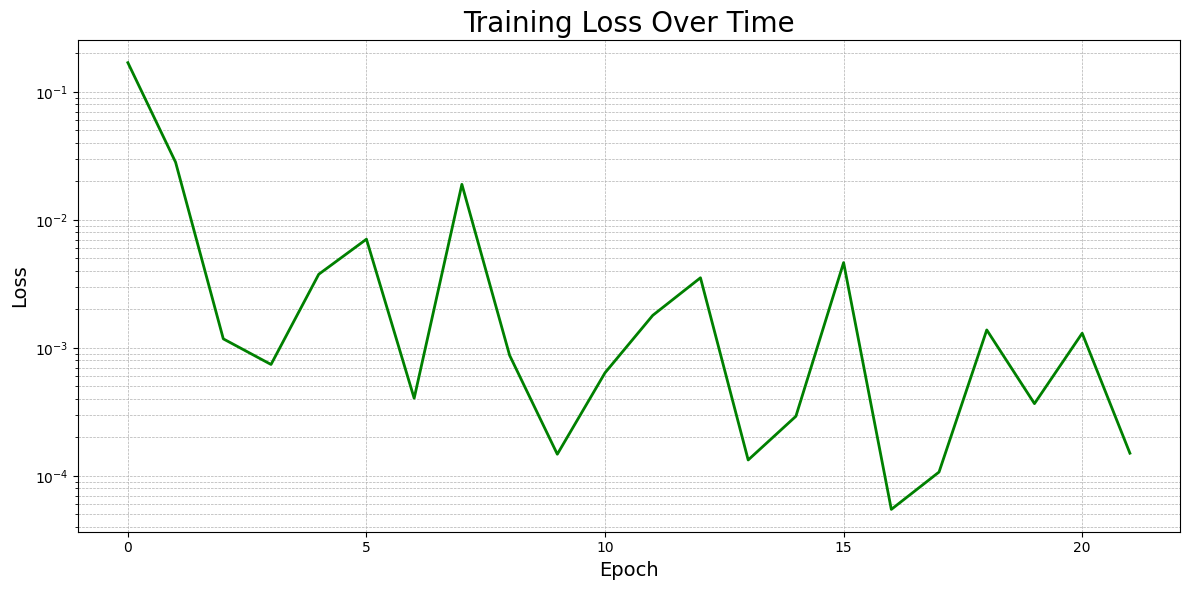

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(losses, color='green', linewidth=2)
plt.title('Training Loss Over Time', fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.tight_layout()
plt.show()

###Test the model

In [40]:
def predict(model, X):
  predictions = []
  for i in range(len(X)):
      output, _ = model.forward(X[i])
      predictions.append(output)
  return np.array(predictions)

In [41]:
predictions = predict(model, X_test)

###Result plot

In [42]:
predictions = predictions.reshape(-1)
y_test = y_test.reshape(-1)

time = np.arange(len(y_test))

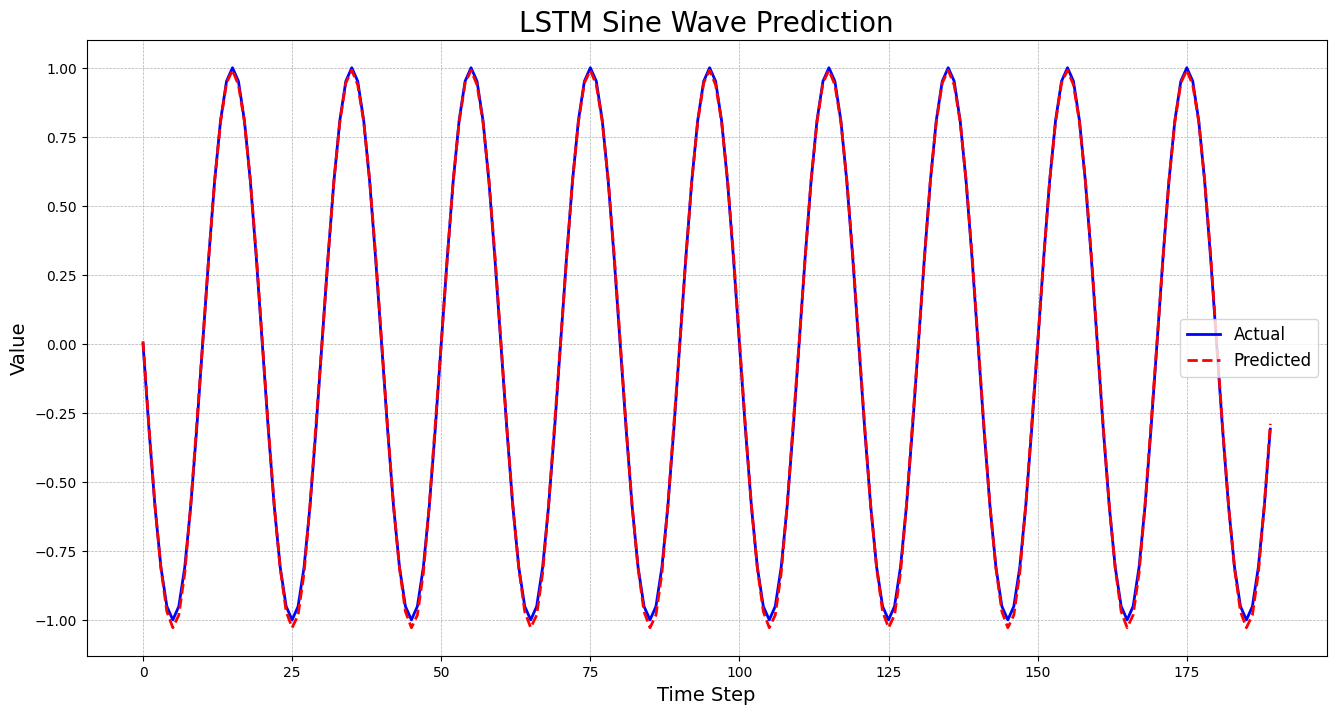

In [43]:
plt.figure(figsize=(16, 8))
plt.plot(time, y_test, label='Actual', color='blue', linewidth=2)
plt.plot(time, predictions, label='Predicted', color='red', linewidth=2, linestyle='--')
plt.title('LSTM Sine Wave Prediction', fontsize=20)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

###MSE-RMSE-MAE

<ipython-input-47-c52db34718d1>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


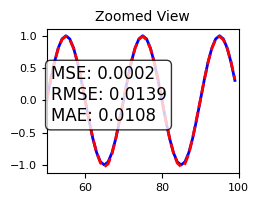

In [47]:
zoom_start, zoom_end = 50, 100
axins = plt.axes([0.5, 0.5, 0.3, 0.3])
axins.plot(time[zoom_start:zoom_end], y_test[zoom_start:zoom_end], color='blue', linewidth=2)
axins.plot(time[zoom_start:zoom_end], predictions[zoom_start:zoom_end], color='red', linewidth=2, linestyle='--')
axins.set_xlim(time[zoom_start], time[zoom_end])
axins.set_ylim(min(y_test[zoom_start:zoom_end].min(), predictions[zoom_start:zoom_end].min()) - 0.1,
               max(y_test[zoom_start:zoom_end].max(), predictions[zoom_start:zoom_end].max()) + 0.1)
axins.set_title('Zoomed View', fontsize=10)
plt.setp(axins.get_xticklabels(), fontsize=8)
plt.setp(axins.get_yticklabels(), fontsize=8)

mse = np.mean((predictions - y_test)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - y_test))
plt.text(0.02, 0.75, f'MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()